In [1]:
%%time
%load_ext autoreload
%autoreload 2

import sys
import os

from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from sklearn.decomposition import _nmf as sknmf
from scipy.stats import rankdata

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf
from gepdynamics import pfnmf

# Move to the project's home directory, as defined in _constants
_utils.cd_proj_home()
print(os.getcwd())

/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 1.42 s, sys: 741 ms, total: 2.16 s
Wall time: 5.65 s


In [2]:
import torch
assert torch.cuda.is_available()
device = 'cuda'

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


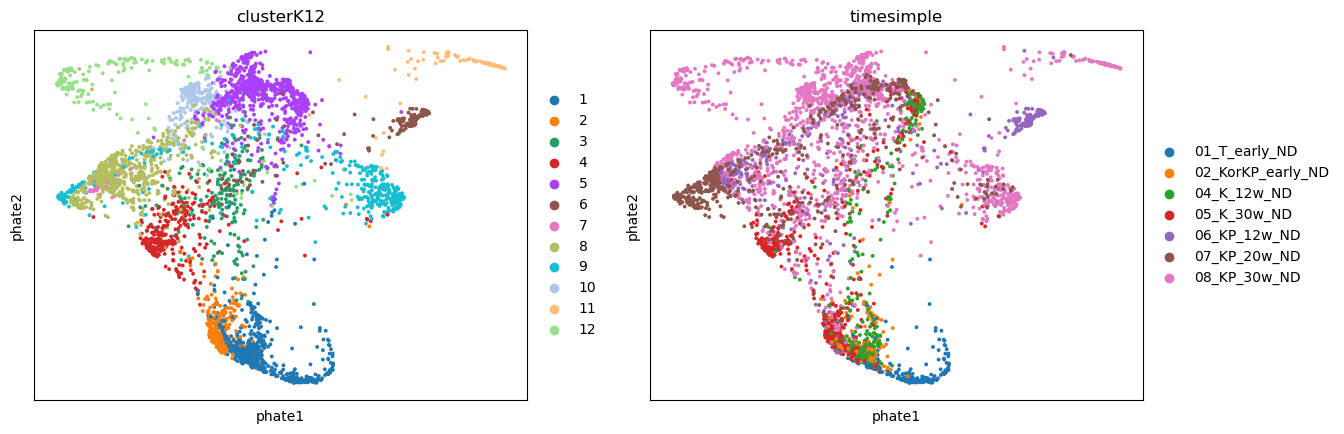

AnnData object with n_obs × n_vars = 3891 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'timesimple_colors', 'clusterK12_colors'
    obsm: 'X_phate', 'X_tsne'

In [3]:
results_dir = _utils.set_dir('results')
orig_adata_path = results_dir.joinpath('marjanovic_mmLungPlate.h5ad')
split_adatas_dir = _utils.set_dir(results_dir.joinpath('marjanovic_mmLungPlate_split'))

adata = sc.read(orig_adata_path)
sc.external.pl.phate(adata, color=['clusterK12', 'timesimple'])
adata

In [4]:
k_12 = sc.read_h5ad(split_adatas_dir.joinpath('04_K_12w_ND_GEPs.h5ad'))
k_12

AnnData object with n_obs × n_vars = 455 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusterK12_colors', 'cnmf_params', 'hvg', 'name', 'sname', 'timesimple_colors'
    obsm: 'X_phate', 'X_tsne', 'row_colors', 'usages', 'usages_norm'
    varm: 'usage_coefs'

In [5]:
k_30 = sc.read_h5ad(split_adatas_dir.joinpath('05_K_30w_ND_GEPs.h5ad'))
k_30

AnnData object with n_obs × n_vars = 505 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusterK12_colors', 'cnmf_params', 'hvg', 'name', 'sname', 'timesimple_colors'
    obsm: 'X_phate', 'X_tsne', 'row_colors', 'usages', 'usages_norm'
    varm: 'usage_coefs'

## Running pfNMF on K30 using the K12 GEPs

### Preparing K12 and K30 data on joint highly variable genes (jHVGs)


In [6]:
var_subset = (k_12.var.n_cells >= 5) & (k_30.var.n_cells >= 5)
obs_subset = adata.obs.timesimple.isin([k_12.uns['name'], k_30.uns['name']])

joint_K12_K30_var = sc.pp.highly_variable_genes(
    adata[obs_subset, var_subset], flavor='seurat_v3',
    n_top_genes=_constants.NUMBER_HVG, inplace=False)
joint_K12_K30_var

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


,means,variances,highly_variable_rank,variances_norm,highly_variable
geneID,,,,,
ENSMUSG00000000001.4_Gnai3,194.888542,5.199244e+04,NaN,0.979725,False
ENSMUSG00000000028.14_Cdc45,5.904417,1.503283e+03,1388.0,2.168086,True
ENSMUSG00000000056.7_Narf,27.791667,4.079177e+03,NaN,0.933303,False
ENSMUSG00000000058.6_Cav2,95.040625,2.757632e+04,NaN,1.421634,False
ENSMUSG00000000078.7_Klf6,206.710417,2.356955e+05,106.0,3.823077,True
...,...,...,...,...,...
ENSMUSG00000114942.1_Lats2,2.674948,2.773830e+02,NaN,1.155601,False
ENSMUSG00000114951.1_AC238811.4,0.074979,2.453808e-01,NaN,0.671681,False
ENSMUSG00000114960.1_AC115289.2,0.161219,1.055823e+01,1951.0,2.026982,True


In [7]:
print("Selecting 2000 joint HVGs, intersection with K12 HVGS is "
      f"{np.sum(joint_K12_K30_var.highly_variable & k_12.var.highly_variable)}"
      ", and with K30 is "
      f"{np.sum(joint_K12_K30_var.highly_variable & k_30.var.highly_variable)}")
joint_K12_K30_HVG = joint_K12_K30_var[joint_K12_K30_var.highly_variable].index

Selecting 2000 joint HVGs, intersection with K12 HVGS is 881, and with K30 is 811


In [8]:
# Variance normalized version of K12 data on the jHVGs
X12 = sc.pp.scale(k_12[:, joint_K12_K30_HVG].X.toarray(), zero_center=False)
print(f'X12.shape = {X12.shape}')
X12[:4, :4]

X12.shape = (455, 2000)


array([[0.        , 0.01119922, 0.        , 0.        ],
       [0.        , 0.24478301, 0.        , 0.        ],
       [0.        , 0.9135366 , 0.        , 0.00701734],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [9]:
# Variance normalized version of K30 data on the jHVGs
X30 = sc.pp.scale(k_30[:, joint_K12_K30_HVG].X.toarray(), zero_center=False)
print(f'X30.shape = {X30.shape}')
X30[:4, :4]

X30.shape = (505, 2000)


array([[1.8623625 , 0.06579945, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33265278, 0.        , 0.        ]], dtype=float32)

### Running NNLS to get K12 GEPs (geps12) on jHVGs

In [10]:
#Parameters
beta_loss = 'kullback-leibler'
max_iter = 500

In [69]:
100 * k_12.obsm['usages_norm'].sum(axis=0) / k_12.n_obs

array([26.991241 , 43.953407 , 12.164866 ,  6.721589 ,  2.9566545,
        7.2122273], dtype=float32)

In [11]:
# Working in the transposed notation to get the programs: X.T ~ H.T @ W.T

nmf_kwargs={'H': k_12.obsm['usages'].T.copy(),
            'update_H': False,
            'tol': _constants.NMF_TOLERANCE,
            'n_iter': max_iter,
            'beta_loss': beta_loss
           }

tens = torch.tensor(X12.T).to(device)

W, H, n_iter = cnmf.nmf_torch(X12.T, nmf_kwargs, tens, verbose=True)
print(f'Error per sample = {(sknmf._beta_divergence(X12.T, W, H, beta_loss) / k_12.n_obs): .3e}')

del tens

geps12 = W.T
geps12.shape

beta 1 loss = 304212.5625, # iterations was 40
Error per sample =  6.686e+02


(6, 2000)

### Decomposing K30 de-novo with same rank as geps12 (on jHVGs)

In [21]:
pfnmf_results = {}
rank_k12 = geps12.shape[0]

In [22]:
nmf_kwargs={
    'n_components': rank_k12,
    'tol': _constants.NMF_TOLERANCE,
    'n_iter': max_iter,
    'beta_loss': beta_loss
   }

tens = torch.tensor(X30).to(device)

W, H, n_iter = cnmf.nmf_torch(X30, nmf_kwargs, tens, verbose=True)

final_loss = sknmf._beta_divergence(X30, W, H, beta_loss)
print(f'Error per sample = {(final_loss / k_30.n_obs): .3e}')

pfnmf_results['de_novo'] = {'W': W, 'H': H, 'n_iter': n_iter, 'final_loss': final_loss}

del tens

beta 1 loss = 328836.15625, # iterations was 200
Error per sample =  6.512e+02


### Decomposing K30 with geps12 and no additional programs

In [23]:
#  x30 ~ W @ geps12

nmf_kwargs={'H': geps12.copy(),
            'update_H': False,
            'tol': _constants.NMF_TOLERANCE,
            'n_iter': max_iter,
            'beta_loss': beta_loss
           }

tens = torch.tensor(X30).to(device)

W, H, n_iter = cnmf.nmf_torch(X30, nmf_kwargs, tens, verbose=True)

final_loss = sknmf._beta_divergence(X30, W, H, beta_loss)
print(f'Error per sample = {(final_loss / k_30.n_obs): .3e}')

pfnmf_results['k12'] = {'W': W, 'H': H, 'n_iter': n_iter, 'final_loss': final_loss}

del tens

beta 1 loss = 384826.8125, # iterations was 50
Error per sample =  7.620e+02


### Decomposing K30 with geps12 and additional programs

In [24]:
# pfnmf is written for constant W_1, so we will transpose as needed:
# x30 ~ W_1 @ geps12 + W_2 @ H_2  <--> x30.T ~ geps12.T @ W_1.T + H_2.T @ W_2.T

for added_rank in range(1, 5):
    print(f"Working on added rank = {added_rank}")
    
    best_loss = np.infty
    
    for repeat in range(10): 
        w1, h1, w2, h2, n_iter = pfnmf.pfnmf(X30.T, geps12.T, rank_2=added_rank, beta_loss=beta_loss,
            tol=_constants.NMF_TOLERANCE, max_iter=max_iter, verbose=False)

        final_loss = pfnmf.calc_beta_divergence(X30.T, w1, w2, h1, h2, beta_loss)
        
        if final_loss <= best_loss:
            best_loss = final_loss
            pfnmf_results[f'k12e{added_rank}'] = {'w1': w1, 'h1': h1, 'w2': w2, 'h2': h2, 'n_iter': n_iter, 'final_loss': final_loss}

            print(f"repeat {repeat}, after {n_iter} iterations reached {final_loss: .4e}"
                 f", per sample loss = {(final_loss / k_30.n_obs): .3e}")

Working on added rank = 1
repeat 0, after 83 iterations reached  3.6811e+05, per sample loss =  7.289e+02
repeat 5, after 133 iterations reached  3.6805e+05, per sample loss =  7.288e+02
Working on added rank = 2
repeat 0, after 294 iterations reached  3.5701e+05, per sample loss =  7.070e+02
Working on added rank = 3
repeat 0, after 327 iterations reached  3.4809e+05, per sample loss =  6.893e+02
repeat 8, after 353 iterations reached  3.4795e+05, per sample loss =  6.890e+02
Working on added rank = 4
repeat 0, after 326 iterations reached  3.3876e+05, per sample loss =  6.708e+02
repeat 6, after 301 iterations reached  3.3840e+05, per sample loss =  6.701e+02
repeat 8, after 373 iterations reached  3.3775e+05, per sample loss =  6.688e+02


## Evaluating the added programs

In [25]:
columns_k12 = [f'k12.p{i}' for i in range(geps12.shape[0])]
sname = k_30.uns["sname"]

coloring_scheme = {'de_novo': '#d62728', 'k12': '#2ca02c', 'k12e1': 'limegreen', 'k12e2': 'yellow', 'k12e3': 'orange', 'k12e4': 'chocolate'}

pfnmf_results.keys()

dict_keys(['de_novo', 'k12', 'k12e1', 'k12e2', 'k12e3', 'k12e4'])

In [58]:
for dict_key, short_name in [('de_novo', 'k30'), ('k12', 'k12')]:
    res_dict = pfnmf_results[dict_key]
    
    res_dict['rank'] = rank_k12
    
    res_dict['norm_usage'] = res_dict['W'] / \
        np.linalg.norm(res_dict['W'], 1, axis=1, keepdims=True)
    
    res_dict['prog_percent'] = res_dict['norm_usage'].sum(axis=0) * 100 / k_30.n_obs

    res_dict['prog_name'] = [f'{short_name}.p{i}' for i in range(rank_k12)]
    
    res_dict['prog_label_2l'] = [name + f'\n({res_dict["prog_percent"][i]: 0.1f}%)' for i, name in enumerate(res_dict['prog_name'])]
    res_dict['prog_label_1l'] = [name + f' ({res_dict["prog_percent"][i]: 0.1f}%)' for i, name in enumerate(res_dict['prog_name'])]   

In [41]:
for index, dict_key in enumerate(['k12e1', 'k12e2', 'k12e3', 'k12e4']):
    added_rank = index + 1
    
    res_dict = pfnmf_results[dict_key]
    
    res_dict['rank'] = rank_k12 + added_rank
    
    usages = np.concatenate([res_dict['h1'], res_dict['h2']], axis=0).T
    
    res_dict['norm_usage'] = usages / np.linalg.norm(usages, 1, axis=1, keepdims=True)
    
    res_dict['prog_percent'] = res_dict['norm_usage'].sum(axis=0) * 100 / k_30.n_obs

    res_dict['prog_name'] = [f'k12e{added_rank}.p{i}' for i in range(rank_k12)]
    res_dict['prog_name'].extend([f'e{added_rank}.p{i}' for i in range(added_rank)])
    
    res_dict['prog_label_2l'] = [name + f'\n({res_dict["prog_percent"][i]: 0.1f}%)' for i, name in enumerate(res_dict['prog_name'])]
    res_dict['prog_label_1l'] = [name + f' ({res_dict["prog_percent"][i]: 0.1f}%)' for i, name in enumerate(res_dict['prog_name'])]   

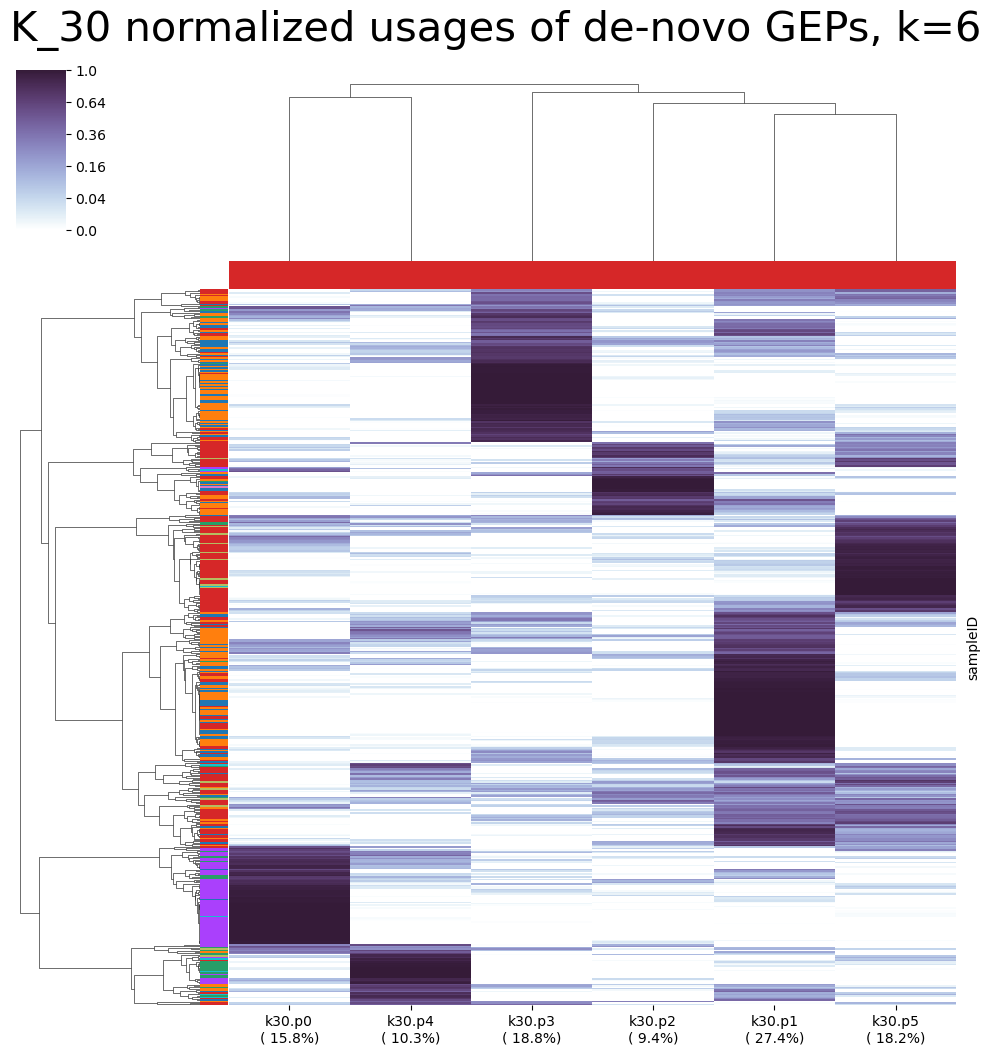

In [42]:
dict_key = 'de_novo'
res_dict = pfnmf_results[dict_key]

title = f'K_30 normalized usages of de-novo GEPs, k={rank_k12}'

un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=res_dict['norm_usage'],
    columns=res_dict['prog_label_2l'], title=title, show=True, sns_clustermap_params={'col_colors': [coloring_scheme[dict_key]] * res_dict['rank']})

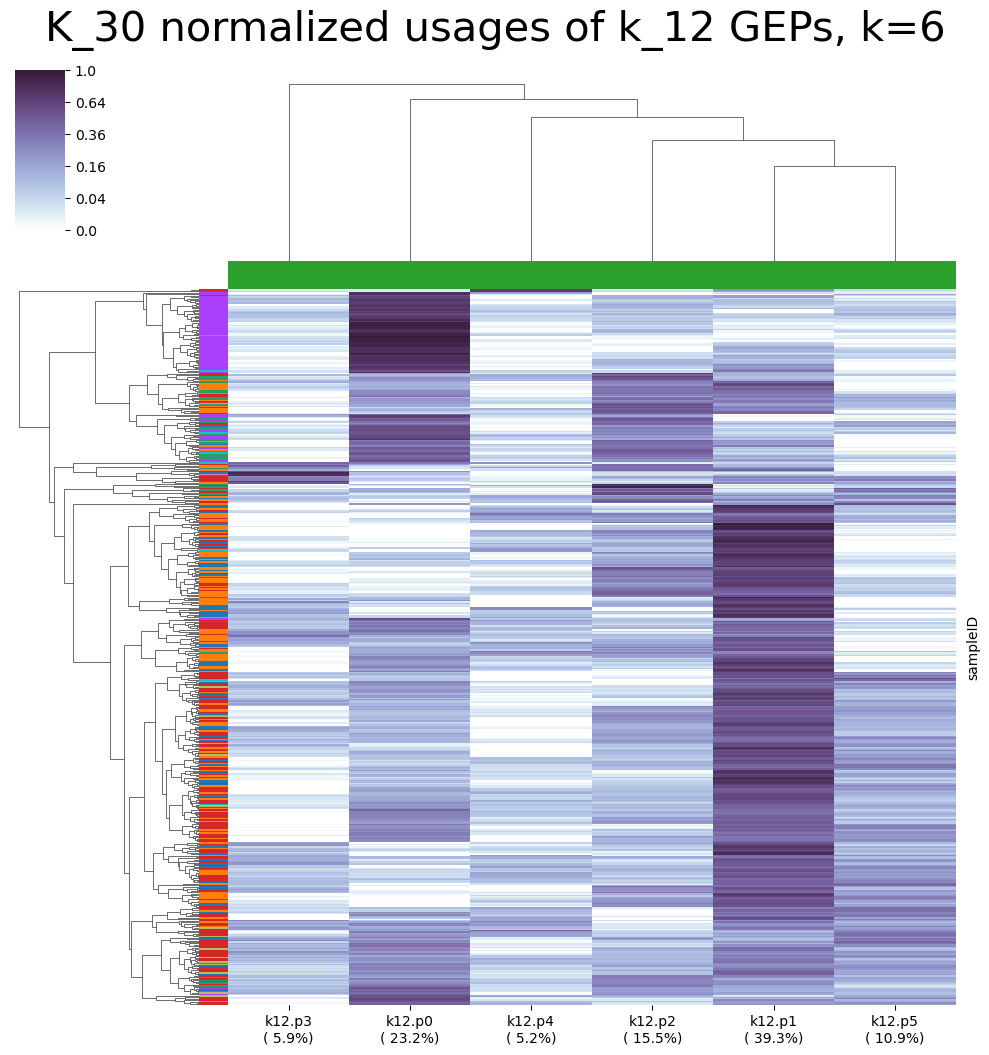

In [43]:
dict_key = 'k12'
res_dict = pfnmf_results[dict_key]

title = f'K_30 normalized usages of k_12 GEPs, k={rank_k12}'

un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=res_dict['norm_usage'],
    columns=res_dict['prog_label_2l'], title=title, show=True, sns_clustermap_params={'col_colors': [coloring_scheme[dict_key]] * res_dict['rank']})

Creating expanded usages DataFrame for added rank 1

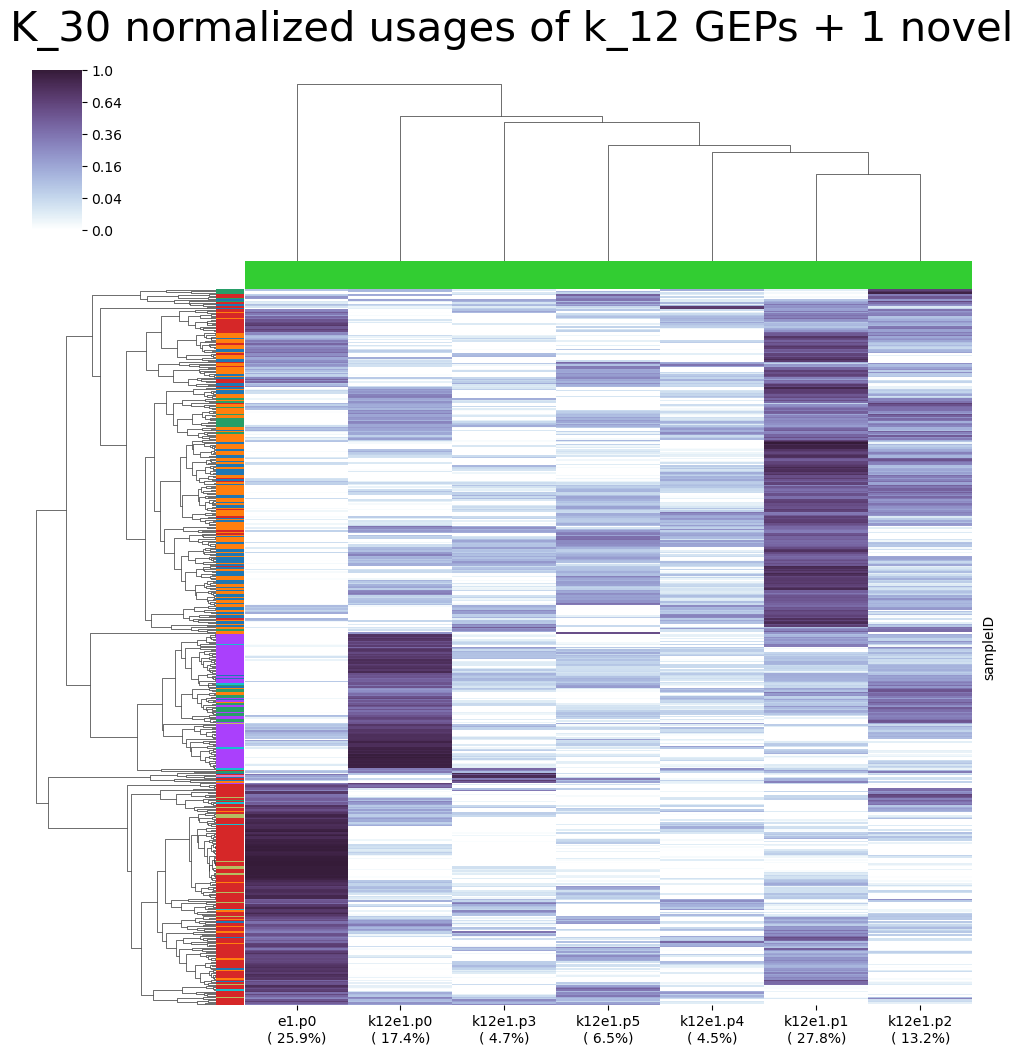

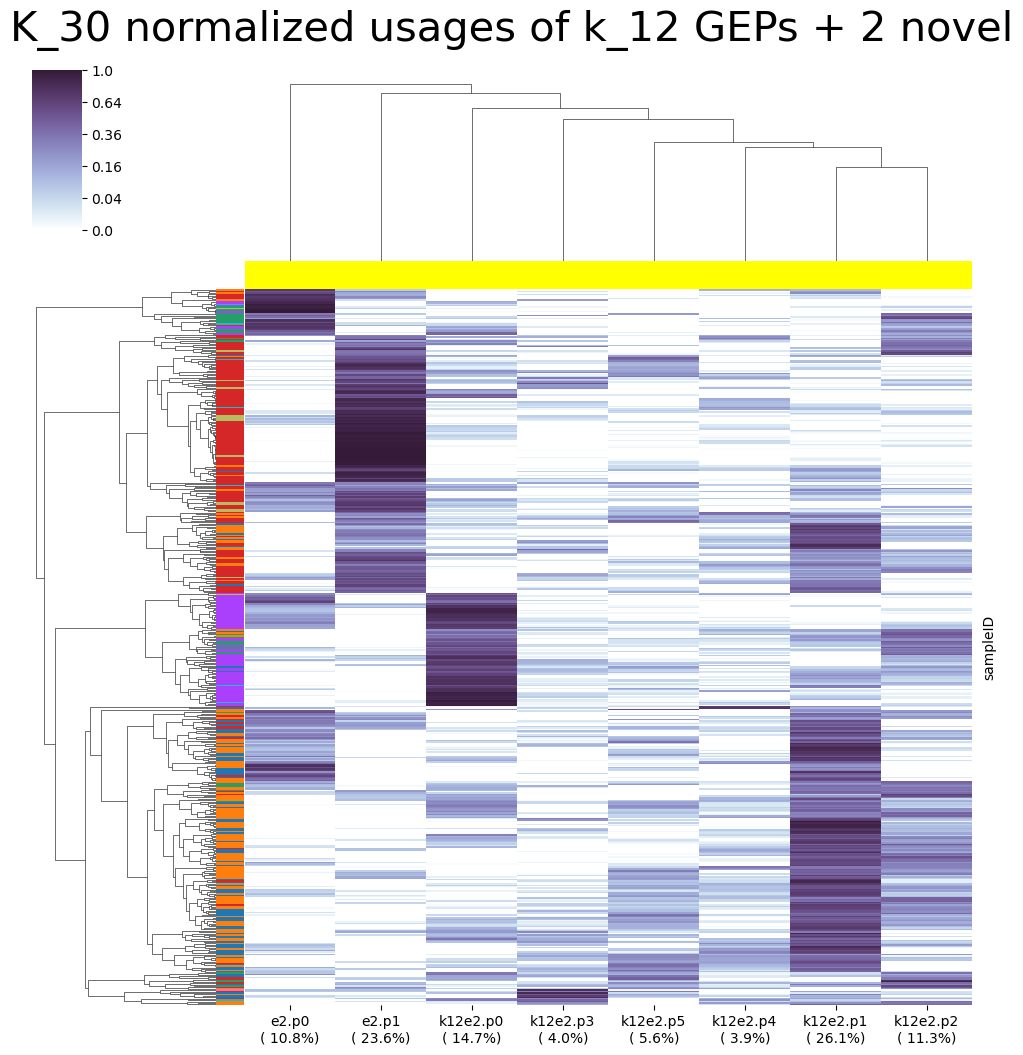

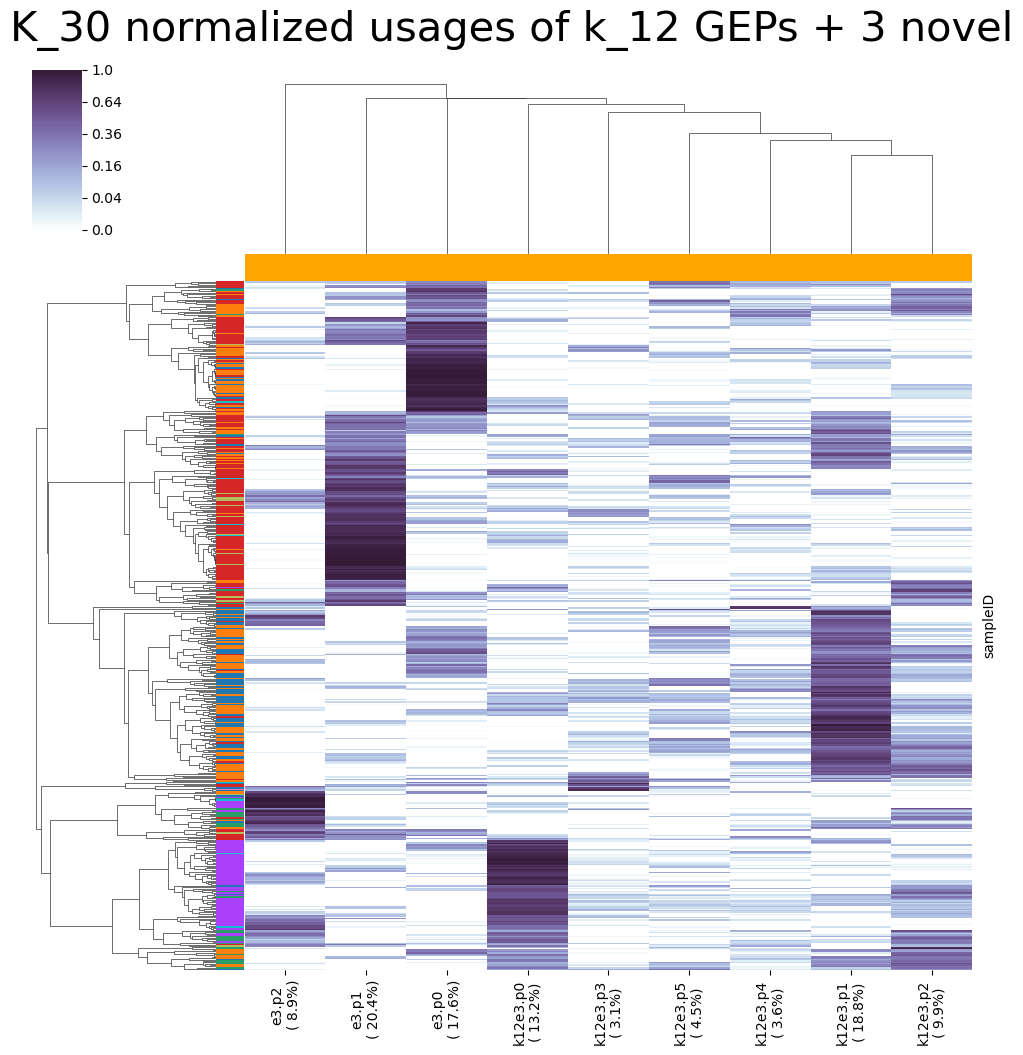

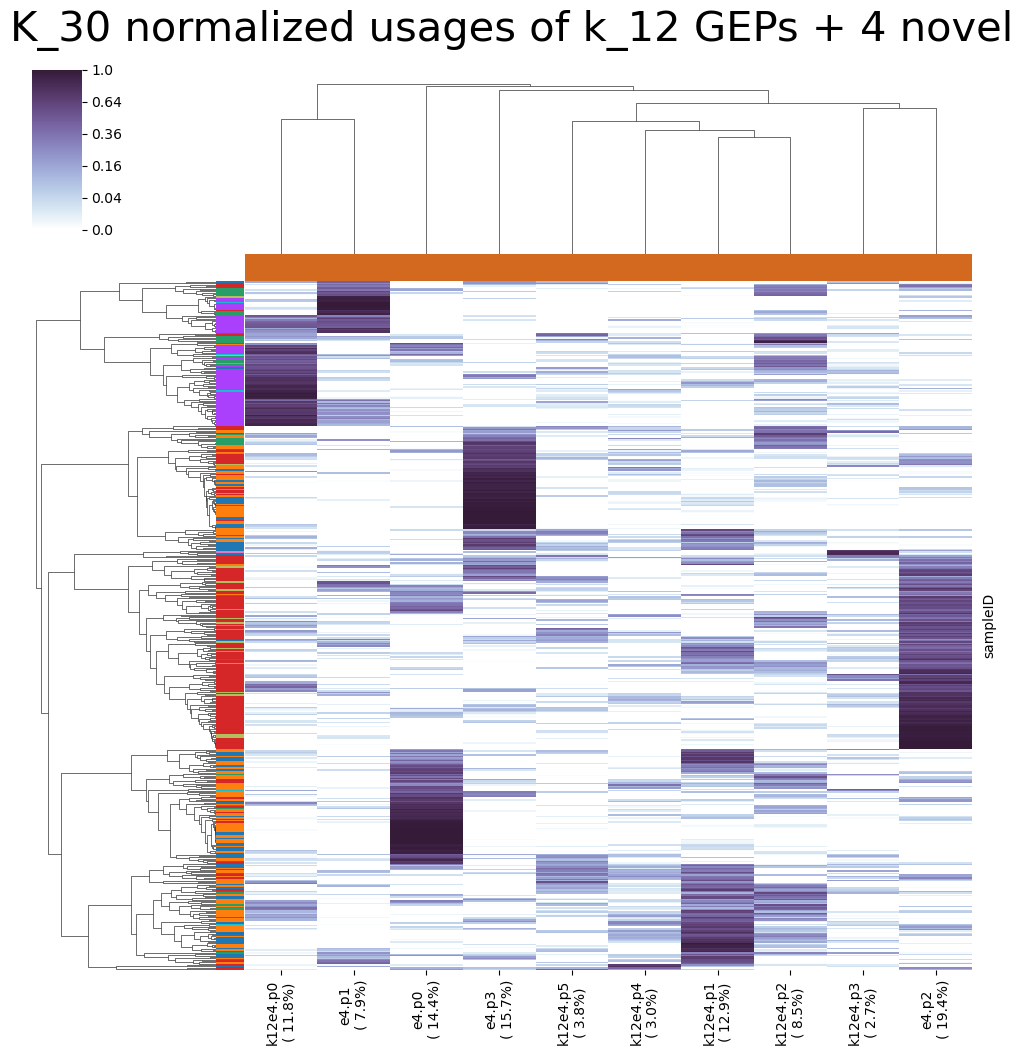

In [45]:
for dict_key in ['k12e1', 'k12e2', 'k12e3', 'k12e4']:
    res_dict = pfnmf_results[dict_key]
    
    title = f'K_30 normalized usages of k_12 GEPs + {res_dict["rank"] - rank_k12} novel'
    
    un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=res_dict['norm_usage'],
        columns=res_dict['prog_label_2l'], title=title, show=True, sns_clustermap_params={'col_colors': [coloring_scheme[dict_key]] * res_dict['rank']})


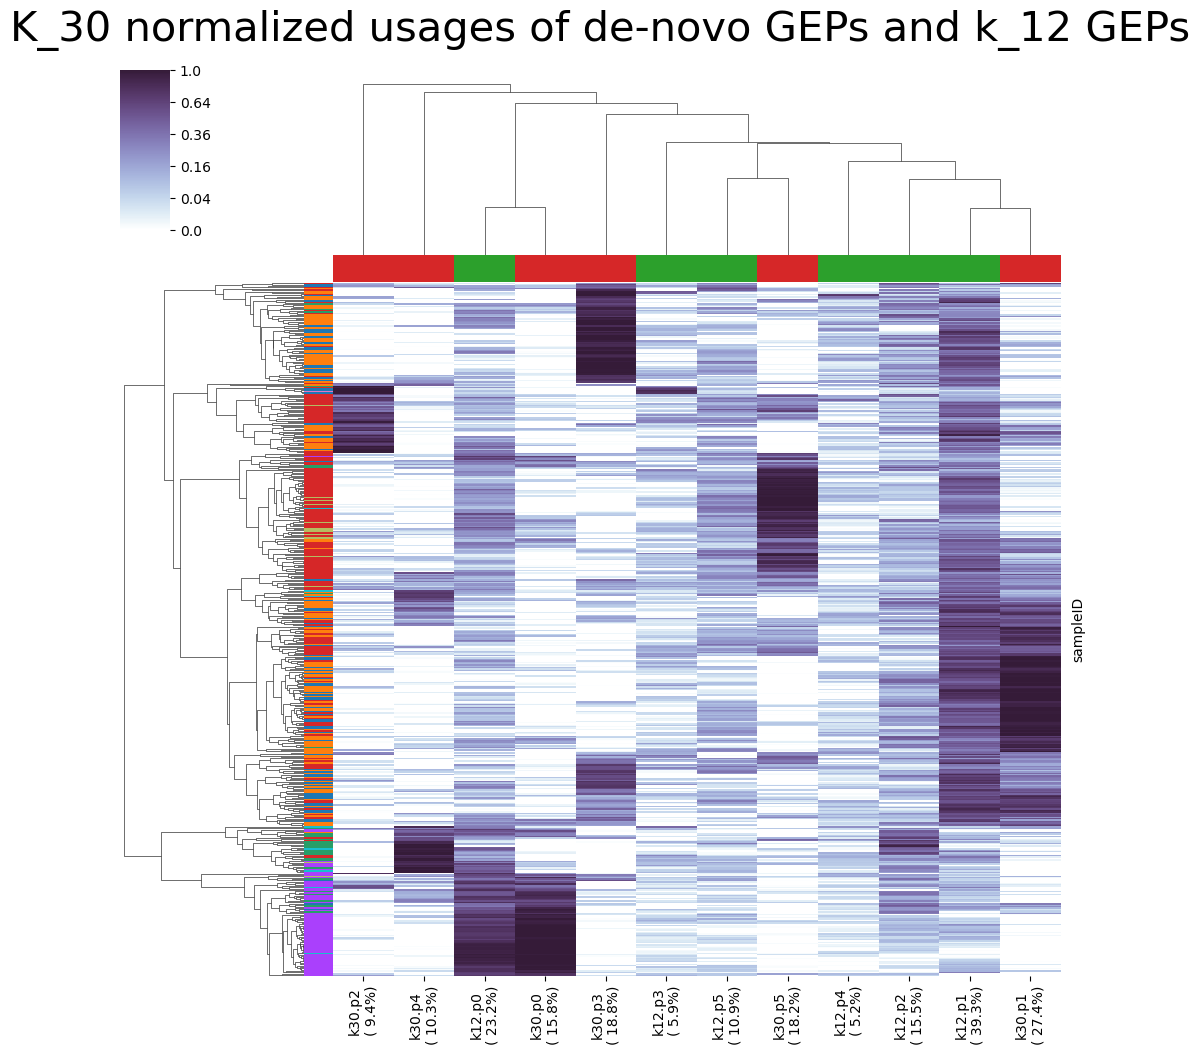

In [59]:
title = f'K_30 normalized usages of de-novo GEPs and k_12 GEPs'

dict_key0 = 'k12'
res_dict0 = pfnmf_results[dict_key0]

dict_key1 = 'de_novo'
res_dict1 = pfnmf_results[dict_key1]

joint_usages = np.concatenate([res_dict0['norm_usage'], res_dict1['norm_usage']], axis=1)

joint_labels = res_dict0['prog_label_2l'] + res_dict1['prog_label_2l']

joint_colors = [coloring_scheme[dict_key0]] * res_dict0['rank'] + [coloring_scheme[dict_key1]] * res_dict1['rank']

un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=joint_usages, columns=joint_labels,
                                             title=title, show=True, sns_clustermap_params={'col_colors': joint_colors})

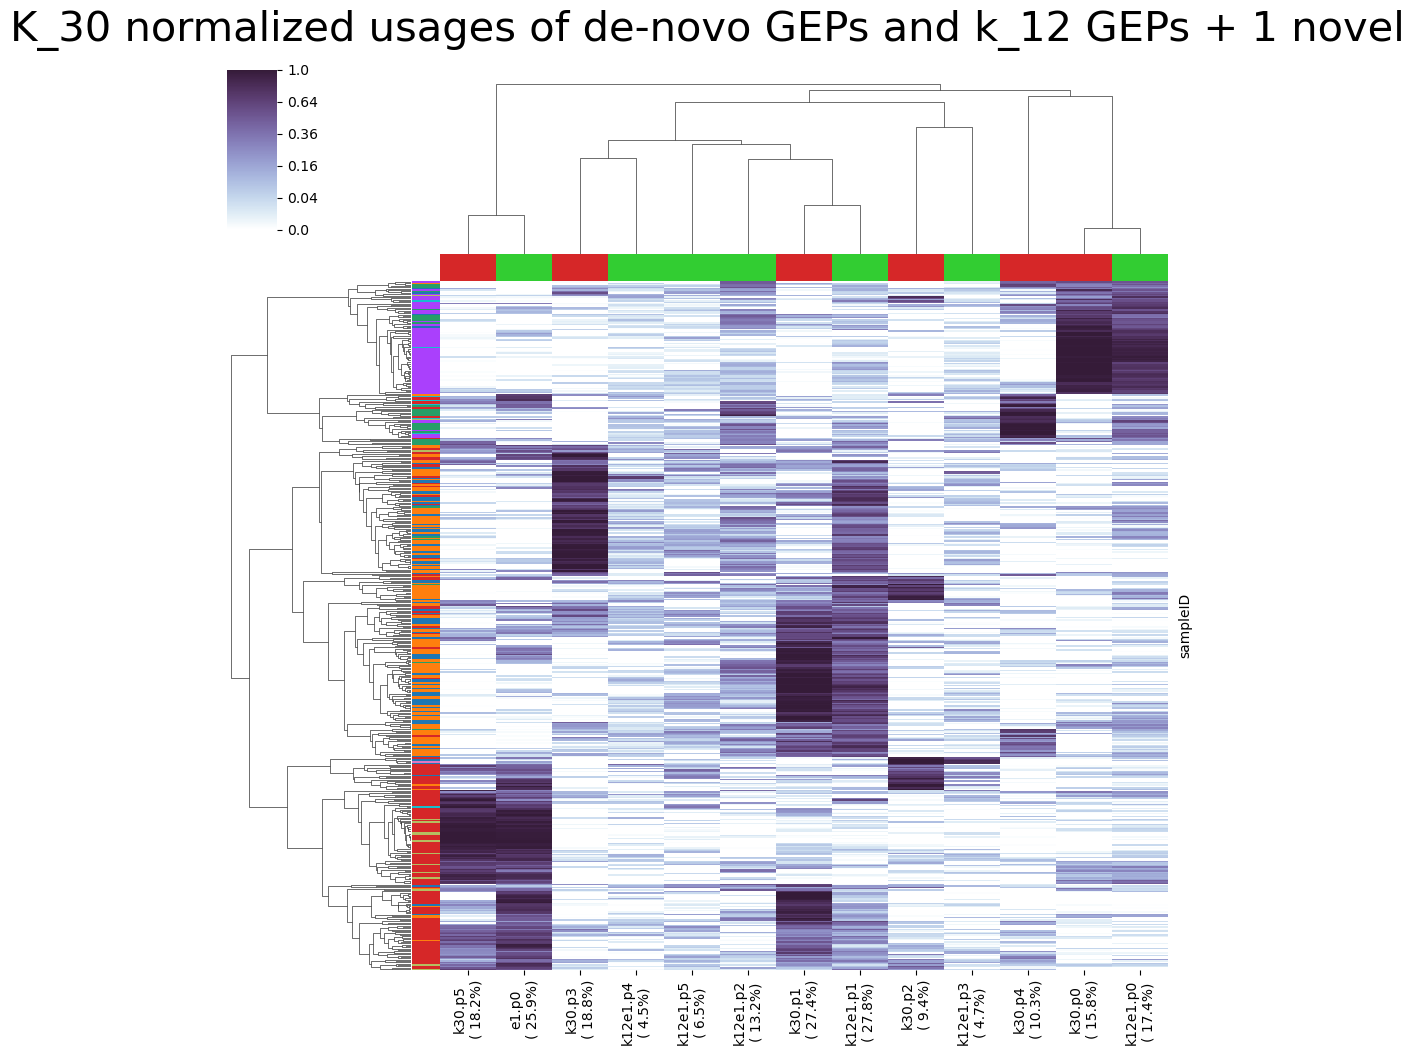

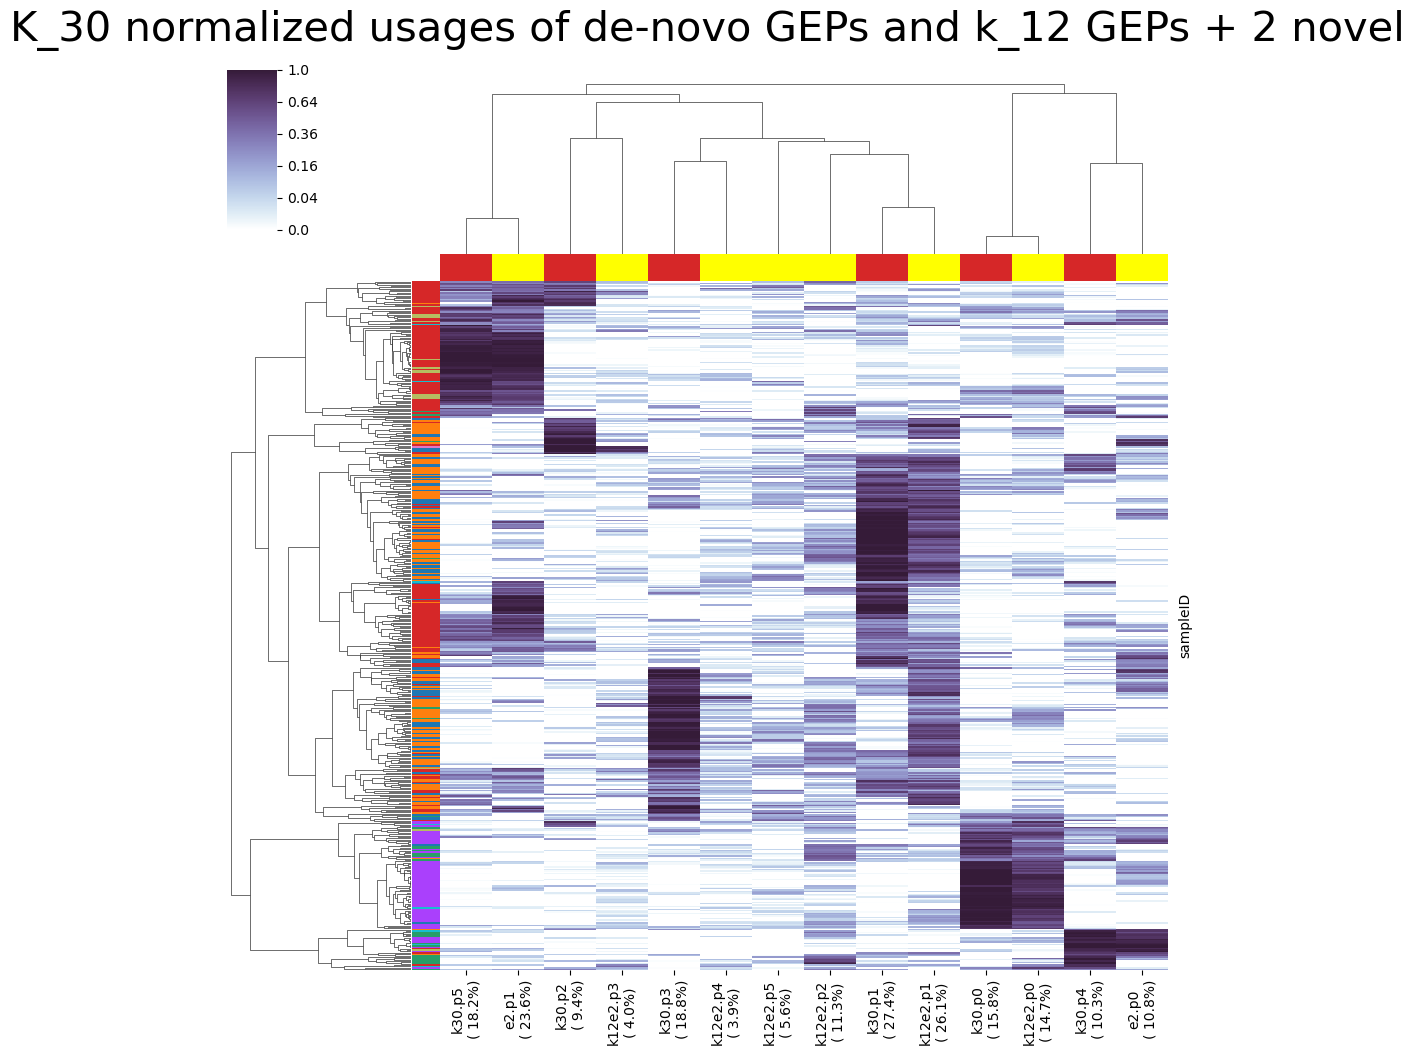

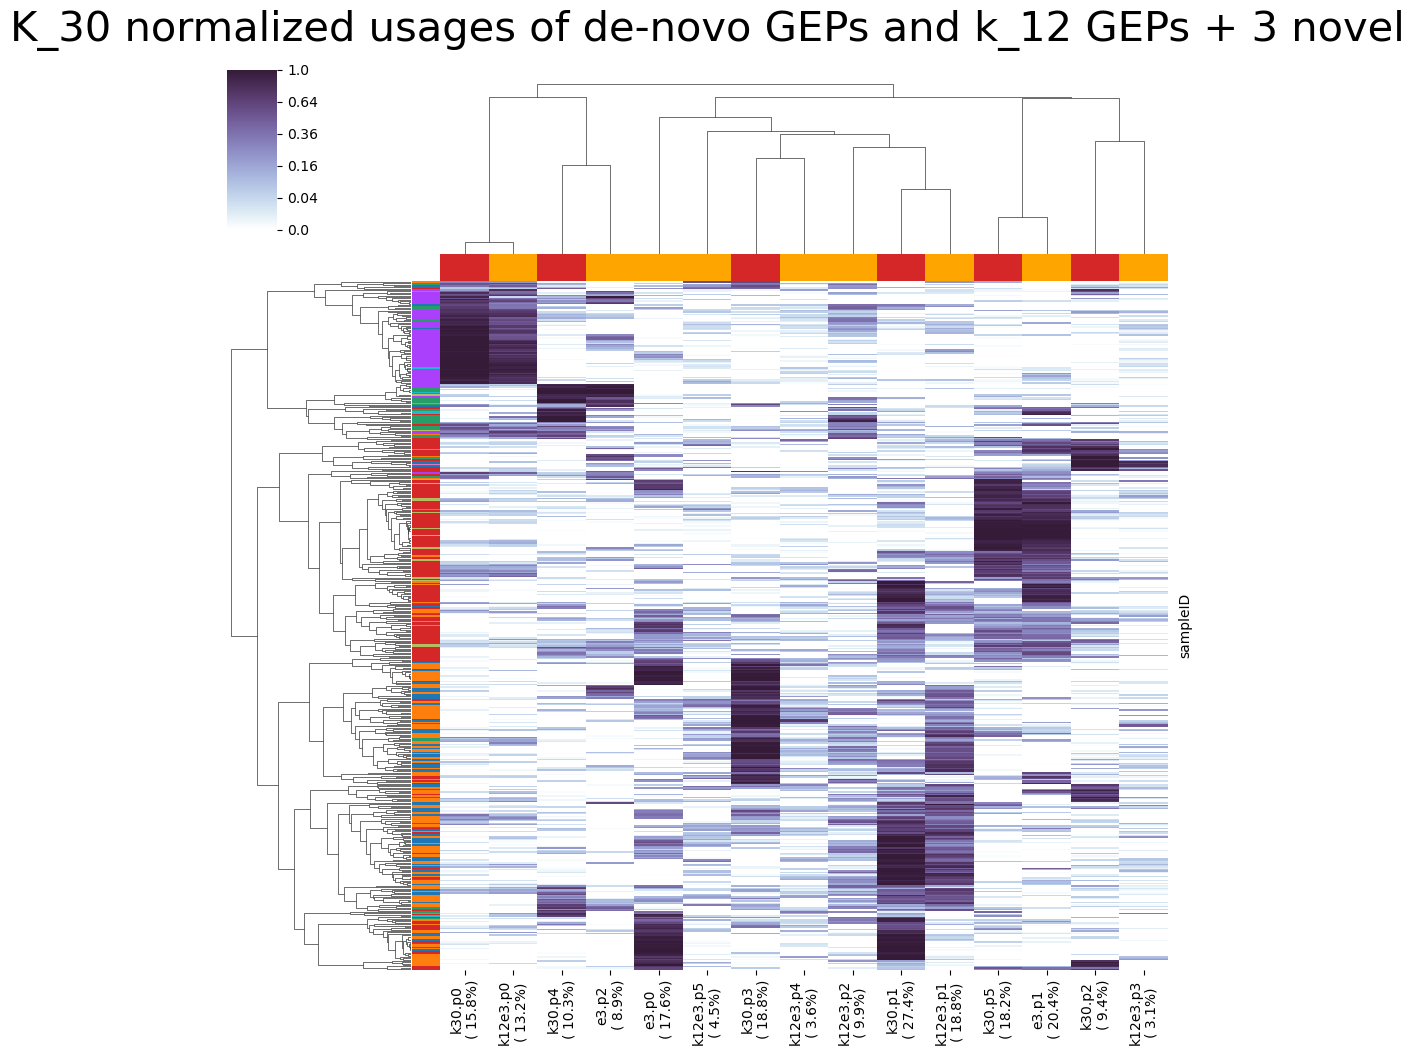

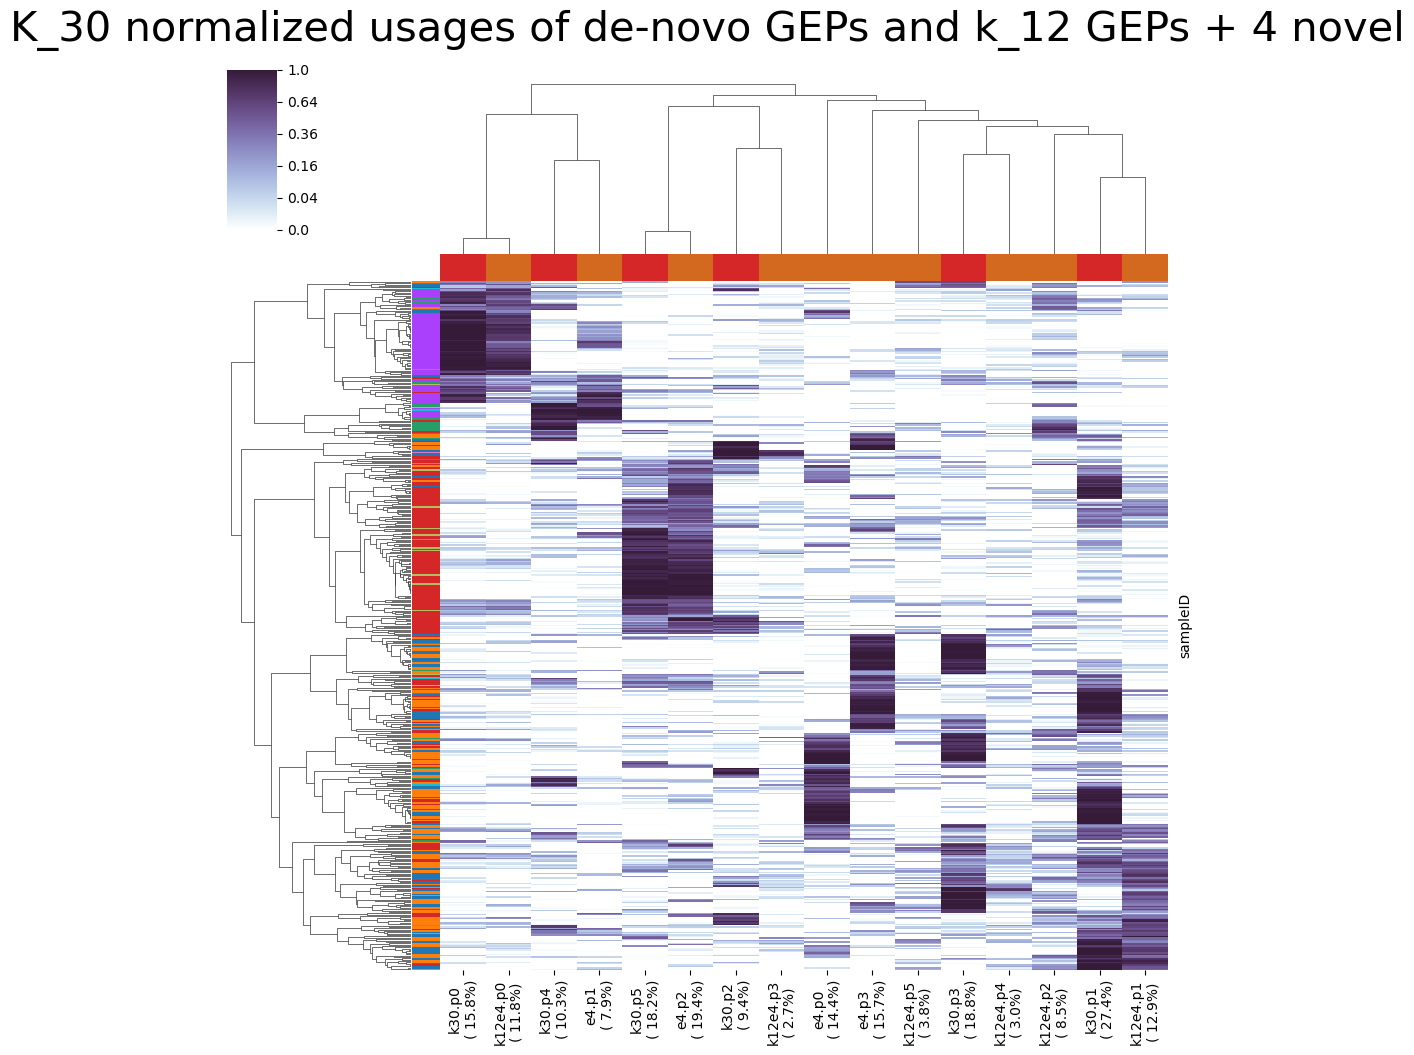

In [51]:
dict_key0 = 'de_novo'
res_dict0 = pfnmf_results[dict_key0]

for dict_key1 in ['k12e1', 'k12e2', 'k12e3', 'k12e4']:
    res_dict1 = pfnmf_results[dict_key1]
    
    title = f'K_30 normalized usages of de-novo GEPs and k_12 GEPs + {res_dict1["rank"] - rank_k12} novel'

    joint_usages = np.concatenate([res_dict0['norm_usage'], res_dict1['norm_usage']], axis=1)

    joint_labels = res_dict0['prog_label_2l'] + res_dict1['prog_label_2l']

    joint_colors = [coloring_scheme[dict_key0]] * res_dict0['rank'] + [coloring_scheme[dict_key1]] * res_dict1['rank']

    un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=joint_usages, columns=joint_labels,
                                                 title=title, show=True, sns_clustermap_params={'col_colors': joint_colors})


apply the usages clustermap function

In [60]:
res_dict0['prog_label_1l']

['k12.p0 ( 23.2%)',
 'k12.p1 ( 39.3%)',
 'k12.p2 ( 15.5%)',
 'k12.p3 ( 5.9%)',
 'k12.p4 ( 5.2%)',
 'k12.p5 ( 10.9%)']

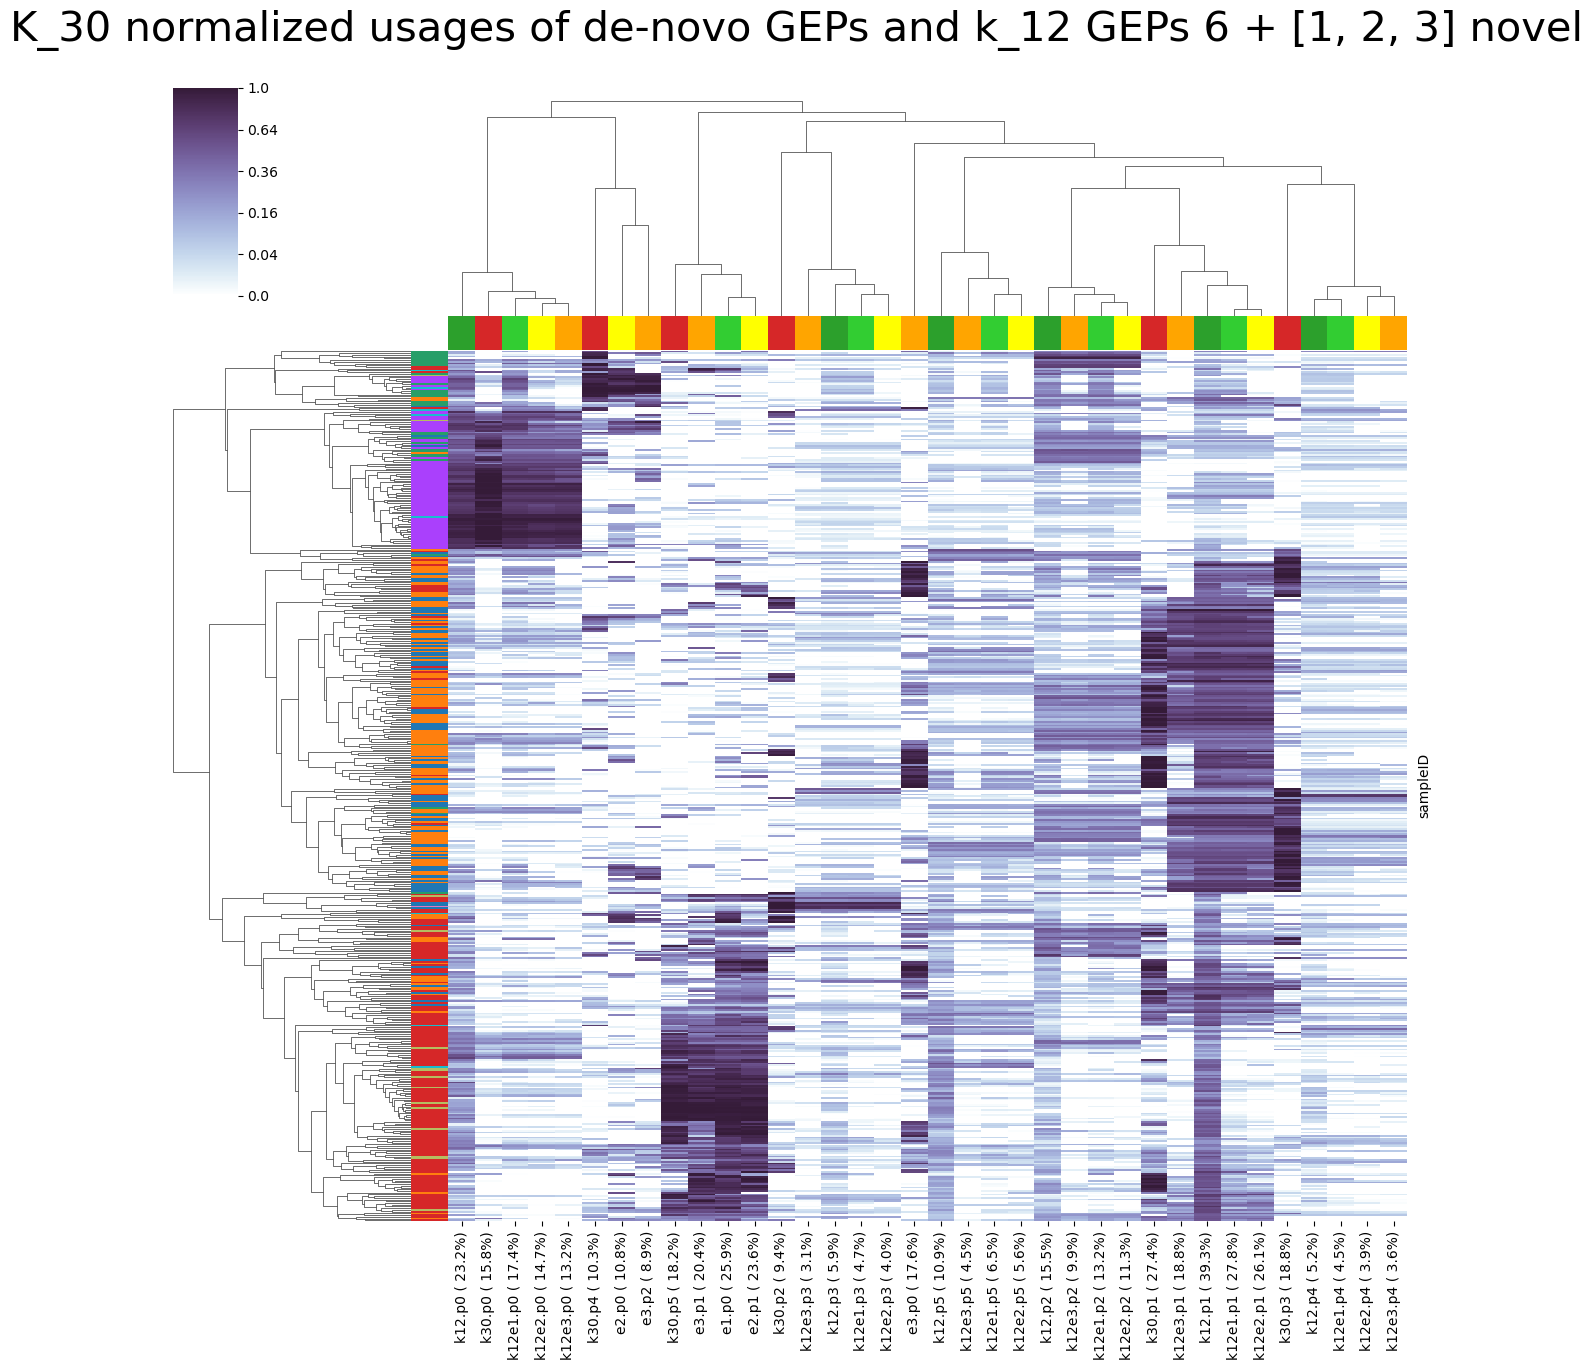

In [64]:
title = f'K_30 normalized usages of de-novo GEPs and k_12 GEPs {rank_k12} + [1, 2, 3] novel'

dict_key0 = 'de_novo'
res_dict0 = pfnmf_results[dict_key0]

joint_usages = res_dict0['norm_usage'].copy()
joint_labels = res_dict0['prog_label_1l'].copy()
joint_colors = [coloring_scheme[dict_key0]] * res_dict0['rank']

for dict_key1 in ['k12', 'k12e1', 'k12e2', 'k12e3']:
    res_dict1 = pfnmf_results[dict_key1]
    
    joint_usages = np.concatenate([joint_usages, res_dict1['norm_usage']], axis=1)

    joint_labels.extend(res_dict1['prog_label_1l'])

    joint_colors.extend([coloring_scheme[dict_key1]] * res_dict1['rank'])

    
un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=joint_usages, columns=joint_labels, title=title,
                                             show=True, sns_clustermap_params={'col_colors': joint_colors, 'figsize': (13, 13)})


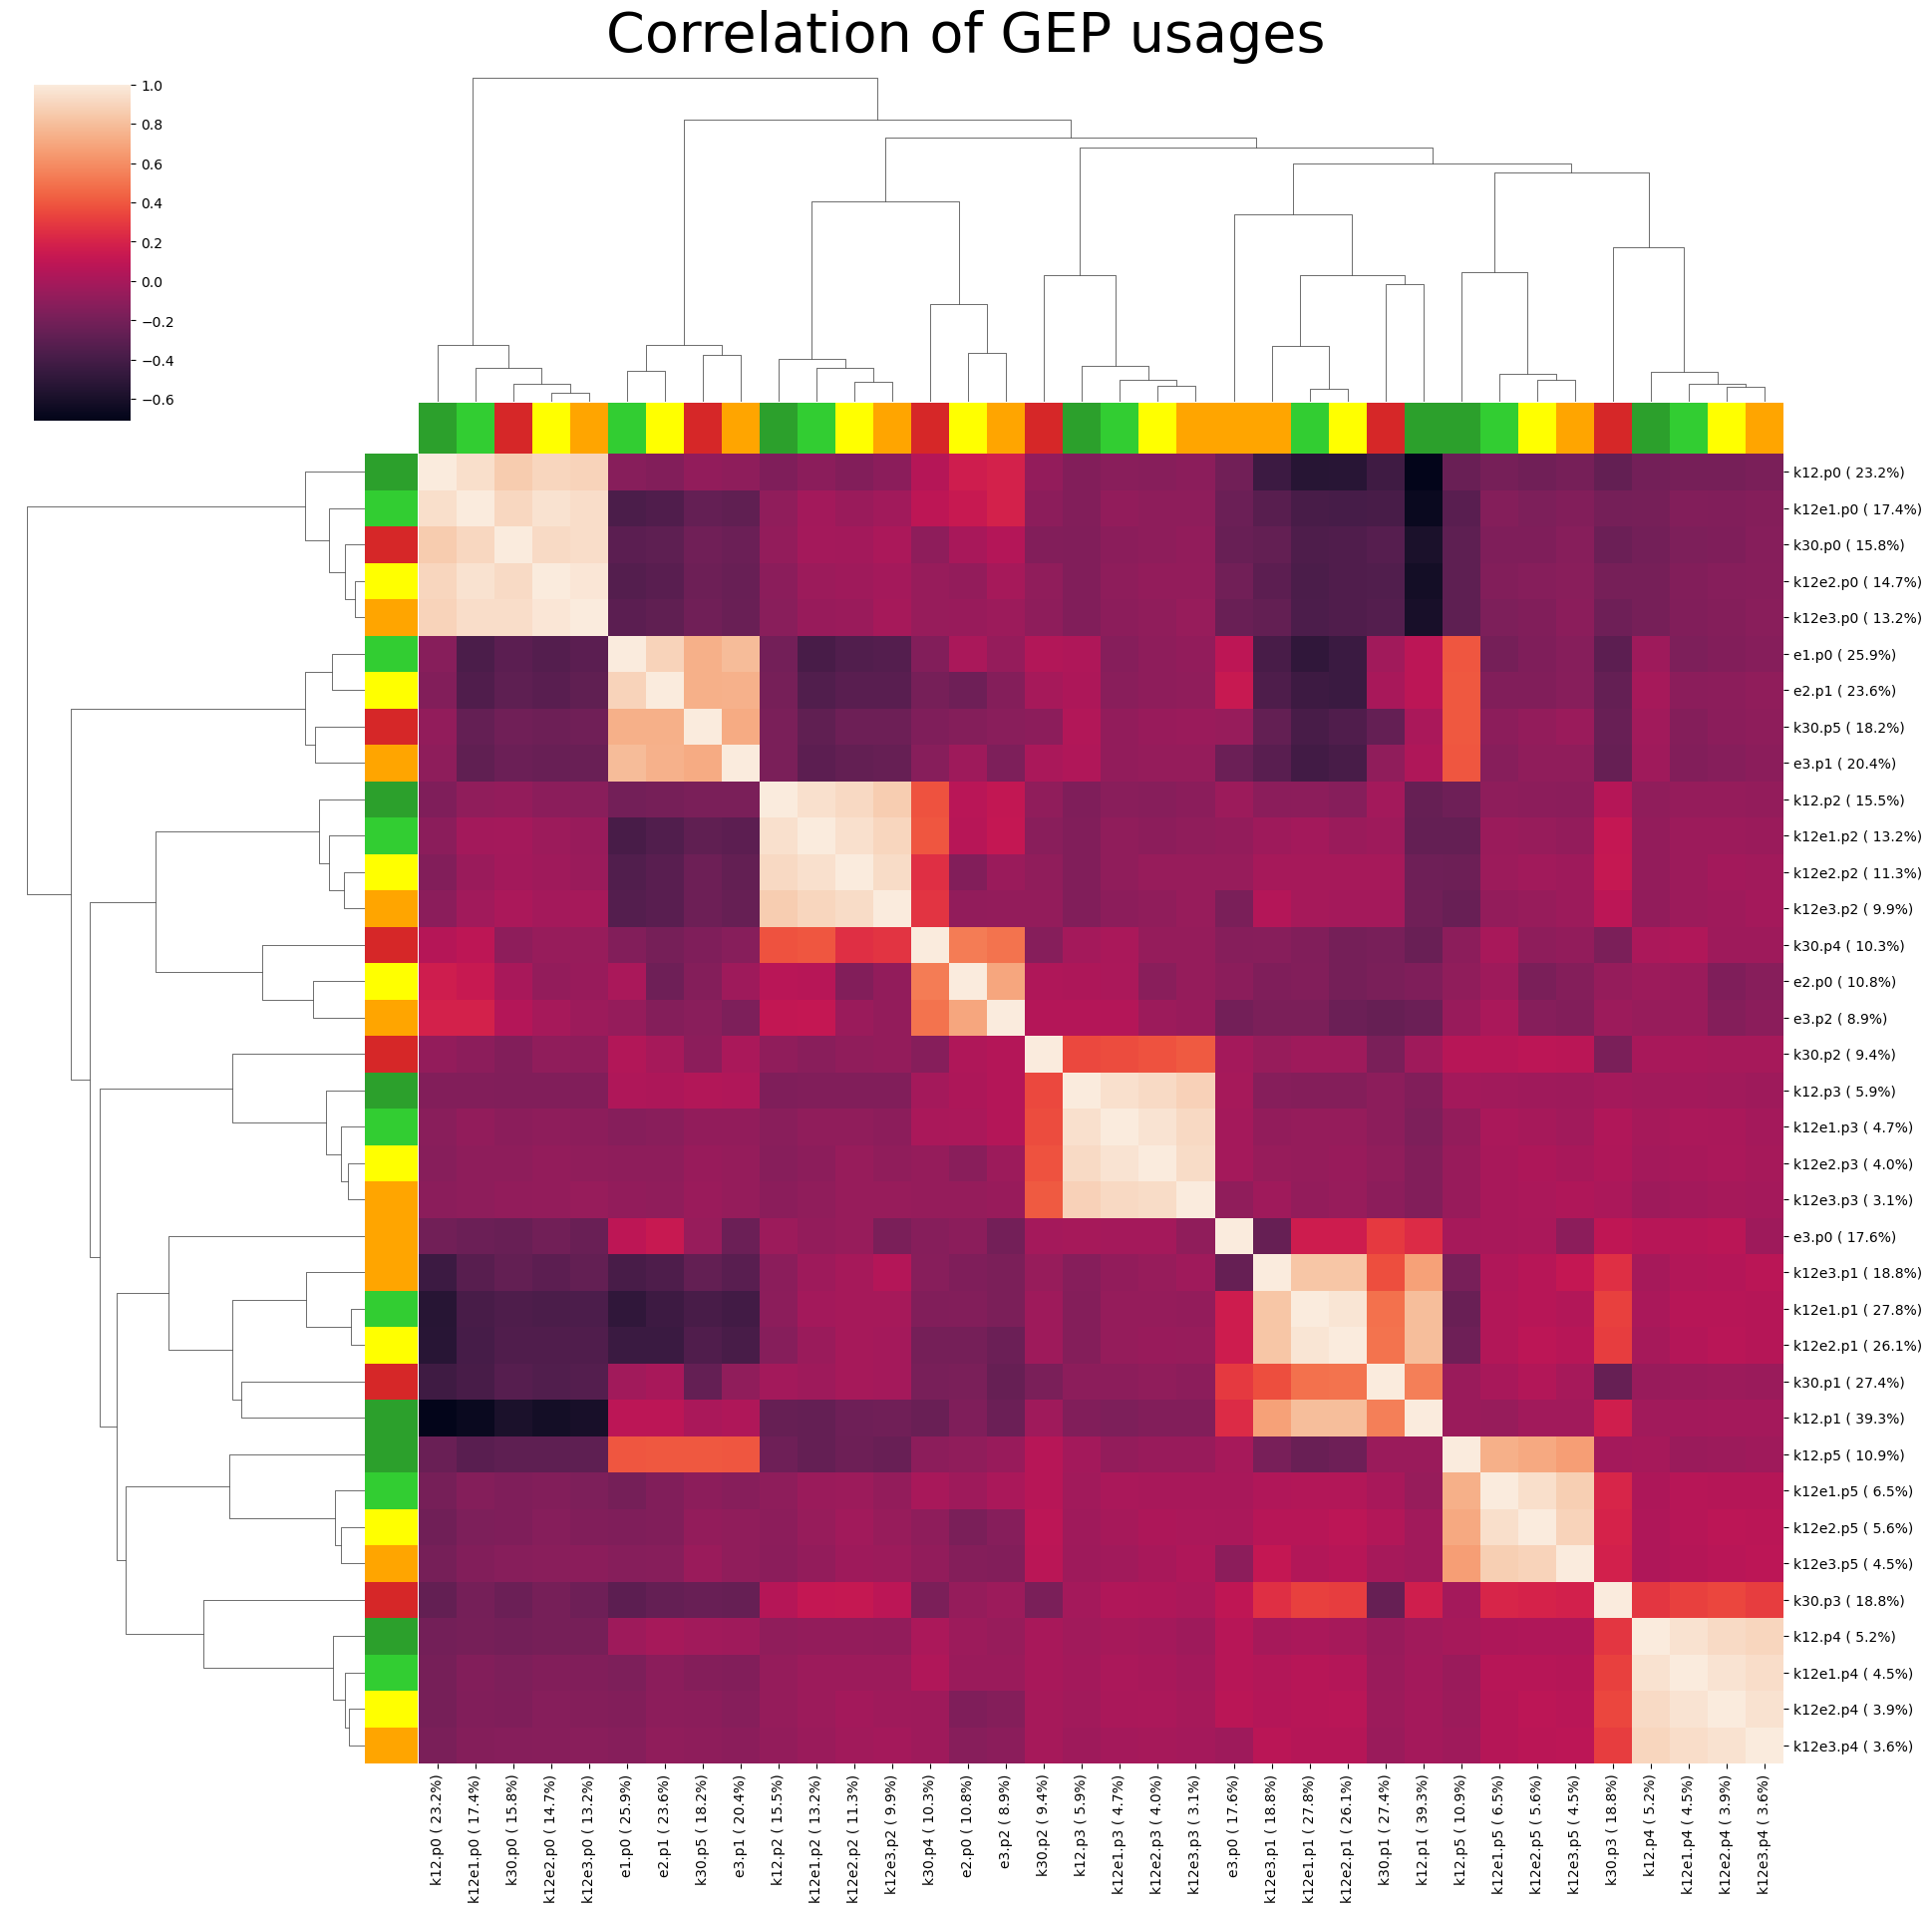

In [65]:
n_programs = joint_usages.shape[1]

pearson_corr = np.corrcoef(joint_usages.T)

un_sns = _utils.sns.clustermap(pd.DataFrame(pearson_corr, index=joint_labels, columns=joint_labels),
                               figsize=(4 + n_programs * 0.43, 4 + n_programs * 0.41),
                               row_colors=joint_colors, col_colors=joint_colors)

un_sns.figure.suptitle('Correlation of GEP usages', fontsize=40, y=1.02)
plt.show()

### Extracting usage coefficients over all genes

In [77]:
z_layer = 'cpm_log1p_zscore'

k_30.layers[z_layer] = sc.pp.normalize_total(k_30, target_sum=1e6, inplace=False)['X']
sc.pp.log1p(k_30, layer=z_layer)
sc.pp.scale(k_30, layer=z_layer)

In [91]:
for dict_key in pfnmf_results.keys():
    res_dict = pfnmf_results[dict_key]
    
    res_dict['gene_coefs'] = pd.DataFrame(
        _utils.fastols(res_dict['norm_usage'], k_30.layers[z_layer]).T,
        index=k_30.var.index,
        columns=res_dict['prog_name'])
    

In [93]:
res_dict['gene_coefs']

,k12e4.p0,k12e4.p1,k12e4.p2,k12e4.p3,k12e4.p4,k12e4.p5,e4.p0,e4.p1,e4.p2,e4.p3
geneID,,,,,,,,,,
ENSMUSG00000000001.4_Gnai3,0.457791,-0.288083,0.091938,0.244883,0.312401,-0.513519,-0.405443,0.698415,0.375774,-0.578959
ENSMUSG00000000028.14_Cdc45,-0.200718,-0.145215,0.008822,4.177996,-0.483804,0.240906,-0.298711,0.294968,-0.169493,-0.092339
ENSMUSG00000000031.15_H19,-0.005855,0.271142,0.228919,-0.123531,0.016610,-0.383312,-0.084714,-0.098283,-0.069623,-0.017601
ENSMUSG00000000049.11_Apoh,-0.057398,-0.078023,-0.124545,-0.103260,-0.125218,-0.126486,0.402858,-0.042331,-0.045503,-0.045118
ENSMUSG00000000056.7_Narf,-0.010556,-0.065995,0.064075,0.062105,0.056501,0.273686,-0.185010,0.388691,0.140623,-0.261335
...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000114960.1_AC115289.2,0.059631,-0.116436,-0.253274,-0.223599,0.729231,-0.216579,-0.081090,-0.003771,0.182654,-0.006887
ENSMUSG00000114967.1_AC161884.2,0.113212,-0.095266,-0.175664,0.628502,-0.213545,-0.346273,-0.064845,0.063784,-0.109729,0.267024
ENSMUSG00000114968.1_AC130217.2,-0.179771,-0.089334,-0.165109,-0.112081,-0.165086,-0.111577,0.278939,0.624650,-0.104099,-0.067939


### Calculating truncated spearman correlation


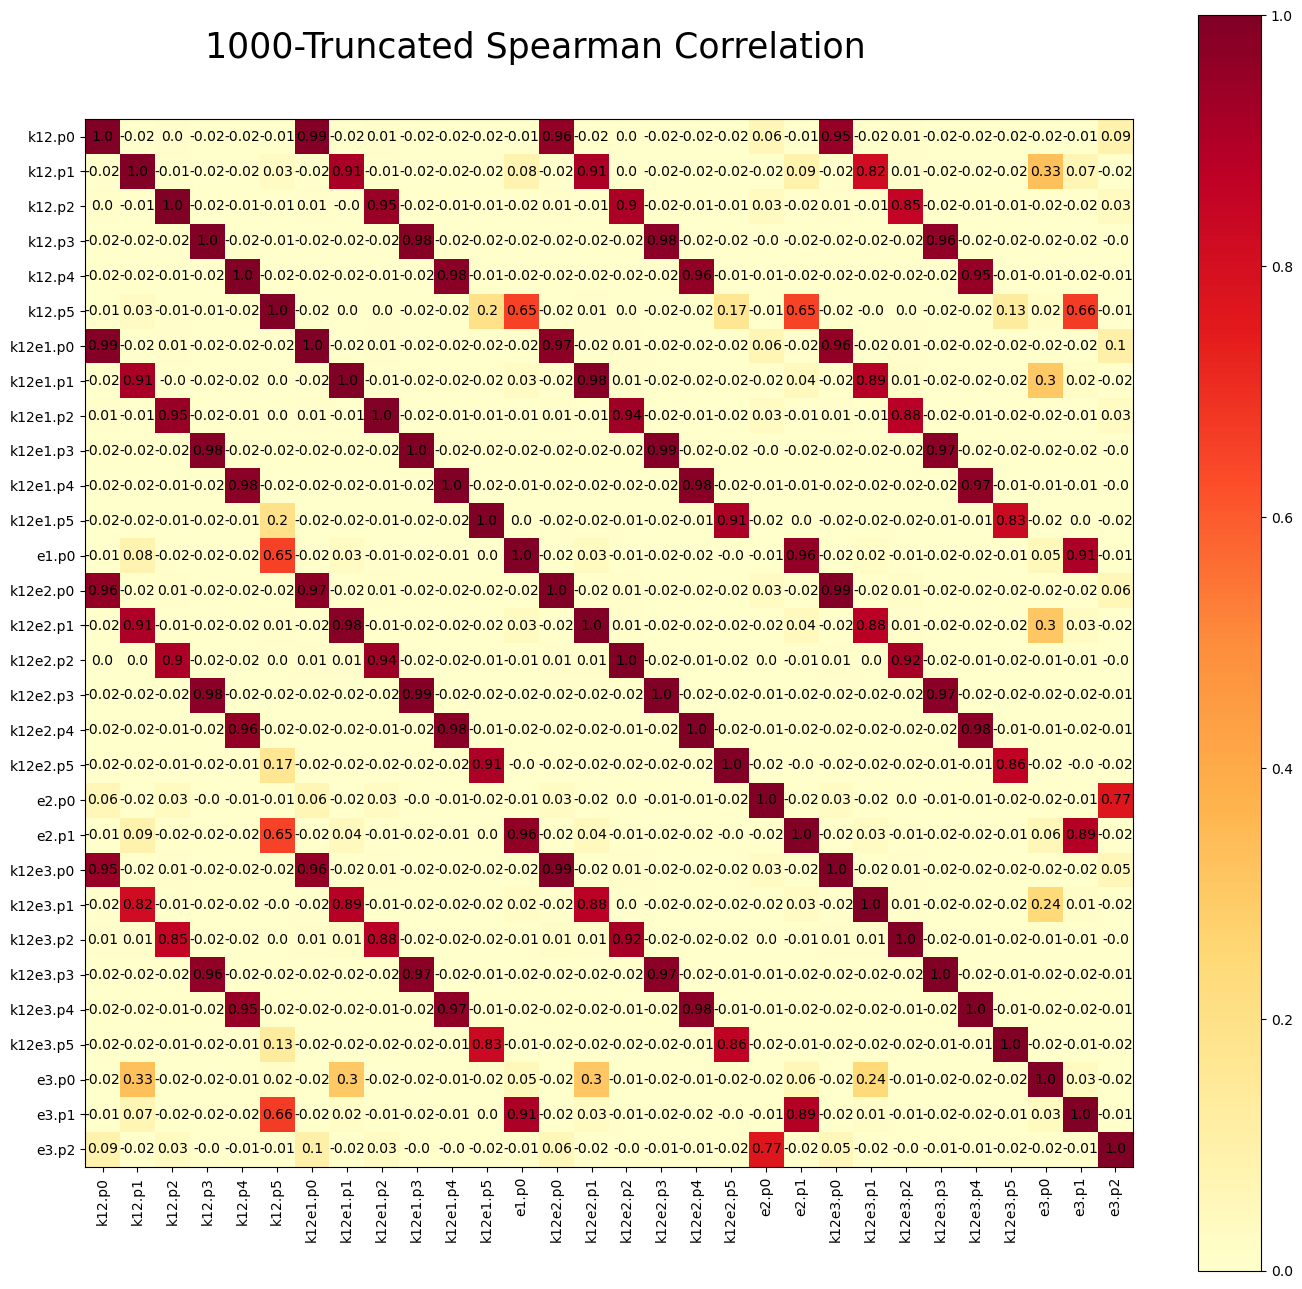

In [104]:
keys = ['k12', 'k12e1', 'k12e2', 'k12e3']

concatenated_spectras = pd.concat([
    pfnmf_results[dict_key]['gene_coefs'].copy() for dict_key in keys], axis=1)

n_genes, n_programs = concatenated_spectras.shape


ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)

ranked_coefs[ranked_coefs > _constants.N_COMPARED_RANKED] = _constants.N_COMPARED_RANKED

spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)

# spearman figure
fig, ax = plt.subplots(figsize=(4 + ranked_coefs.shape[1] * 0.43,
                                4 + ranked_coefs.shape[1] * 0.41))

_utils.heatmap_with_numbers(
    spearman_corr, ax=ax, param_dict={'vmin': 0, 'vmax': 1})

ax.xaxis.tick_bottom()
ax.set_xticklabels(concatenated_spectras.columns, rotation='vertical')
ax.set_yticklabels(concatenated_spectras.columns)
ax.set_title(f'{_constants.N_COMPARED_RANKED}-Truncated Spearman Correlation',
             size=25, y=1.05, x=0.43)

plt.show(fig)

# fig.savefig(RESULTS_DIR.joinpath(
#     f'correlation_spearman_{utils.N_COMPARED_RANKED}_truncated.png'),
#     dpi=180, bbox_inches='tight')

# plt.close(fig)


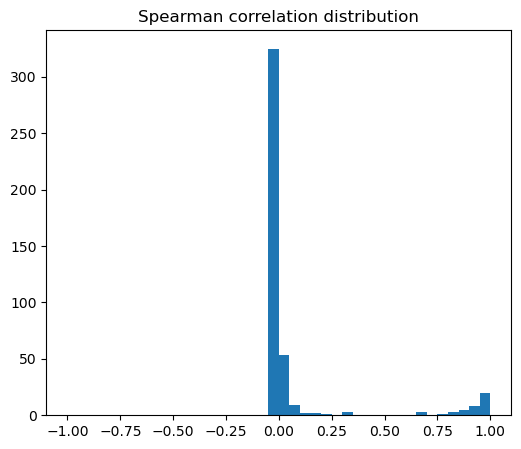

In [105]:
# correlation histogram
fig, ax = plt.subplots(figsize=(6, 5))

plt.hist(spearman_corr[np.triu_indices_from(pearson_corr, k=1)],
         bins=np.linspace(-1, 1, 41))
ax.set_title('Spearman correlation distribution')
plt.show()

# fig.savefig(RESULTS_DIR.joinpath('correlation_histogtam_pearson.png'),
#             dpi=180, bbox_inches='tight')

# plt.close(fig)

In [109]:
for key in pfnmf_results.keys():
    print(key)
    print(pfnmf_results[key]['final_loss'] / 505)

de_novo
651.1607054455445
k12
762.0335396039604
k12e1
728.8038422409942
k12e2
706.9510832675592
k12e3
689.0014893406338
k12e4
668.8027283466748
